# Membuat Model Prediksi Luas Penyebaran Kebakaran Hutan

Dalam notebook ini, akan dibuat sebuah model prediksi untuk mengetahui luas penyebaran kebakaran hutan menggunakan Neural Network yang telah dioptimisasi dengan Hyperparameter Tuning dan Performance Improvement. Dataset yang digunakan diunduh dari https://archive.ics.uci.edu/ml/datasets/forest+fires, dengan tujuan awal pengumpulan data untuk memprediksi area kebakaran hutan di Portugal.

Pertama, import terlebih dahulu library yang akan digunakan.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


Kemudian print isi dataset.

In [2]:
fire = pd.read_csv('forestfires.csv')
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Dapat diperhatikan bahwa di antara kolom numerikal, terdapat dua kolom yang berisi string, yaitu month dan day. Notebook ini akan mengubah value per kolom secara manual dengan .replace() alih-alih menggunakan One Hot Encoding agar tidak menambahkan fitur/kolom baru serta mengubah tipe data kedua kolom tersebut.

In [3]:
fire.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
fire.day.replace(('mon','tue','wed','thu','fri','sat','sun'), (1,2,3,4,5,6,7), inplace=True)

In [4]:
fire['month'] = fire['month'].astype('int')
fire['day'] = fire['day'].astype('int')

Kemudian tampilkan kembali value-nya setelah pengubahan tersebut.

In [5]:
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Informasi Awal

Cari tahu informasi mengenai dataset, seperti:
- Jumlah kolom dan baris dengan .shape()
- Tipe data dan missing value dengan .info()
- Statistik dasar dengan .describe()

In [6]:
fire.shape

(517, 13)

- Terdapat 517 baris dengan 13 kolom.

In [7]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int32  
 3   day     517 non-null    int32  
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int32(2), int64(3)
memory usage: 48.6 KB


- Tidak terdapat missing value. Semua tipe data (setelah penggantian tipe data month dan day) merupakan tipe data numerikal.

In [8]:
fire.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


- Persebaran data kurang merata pada kebanyakan kolom. Skew yang terlihat paling jelas terdapat pada kolom area, di mana perbedaan antara minimum dan maximumnya menyentuh angka 1090, sementara 50%-nya hanya 0.52.

## Eksplorasi Data

Kemudian, lihat korelasi antar kolom dalam heatmap.

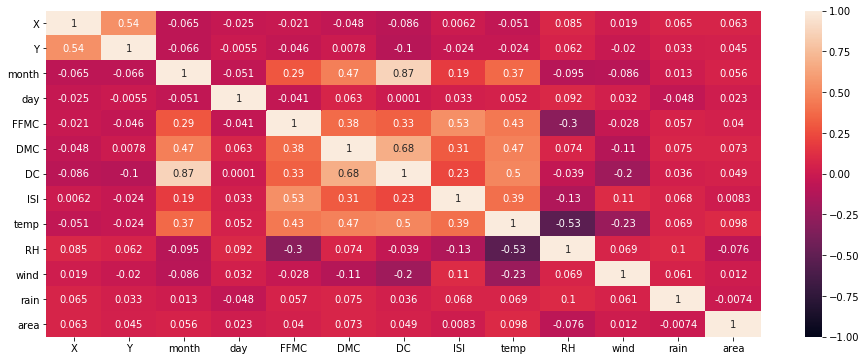

In [9]:
plt.figure(figsize=(16, 6))
sns.heatmap(fire.corr(), vmin=-1, vmax=1, annot=True);

- Korelasi antar kolom sangat kecil, dengan kebanyakan nilai berupa dua angka di belakang koma. Terdapat pula beberapa kolom yang berkorelasi negatif dengan kolom lainnya.

Selanjutnya, lihat persebaran data tiap kolom dalam histogram.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C04920C0B8>,
      dtype=object)

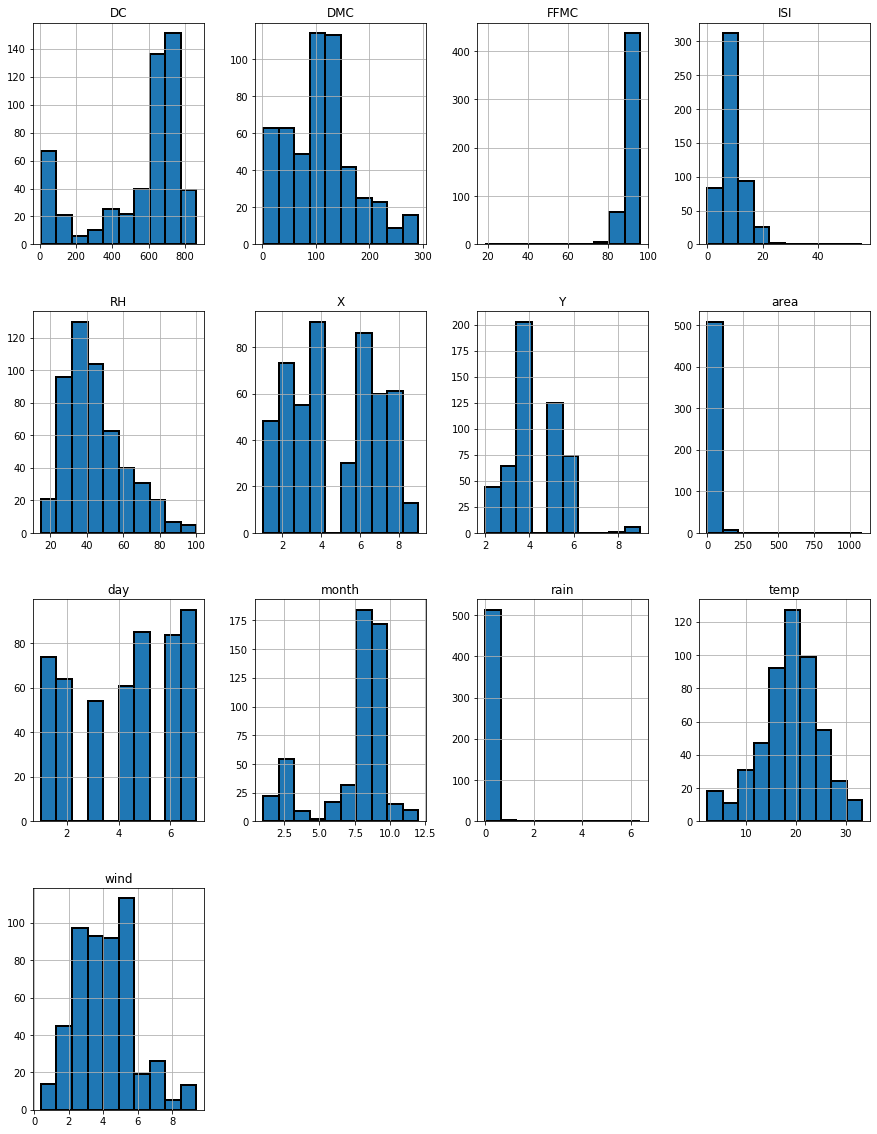

In [10]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
fire.hist(edgecolor='black', ax=ax, linewidth=2)

- Distribusi data pada kolom area bukan merupakan distribusi normal, kemungkinan perlu dilakukan transformasi data sebelum digunakan untuk model prediksi.
- Kebanyakan data yang dikumpulkan pada dataset ini merupakan data sekitar bulan Agustus-Oktober. 

Dalam langkah selanjutnya, akan dilihat outlier pada masing-masing kolom.

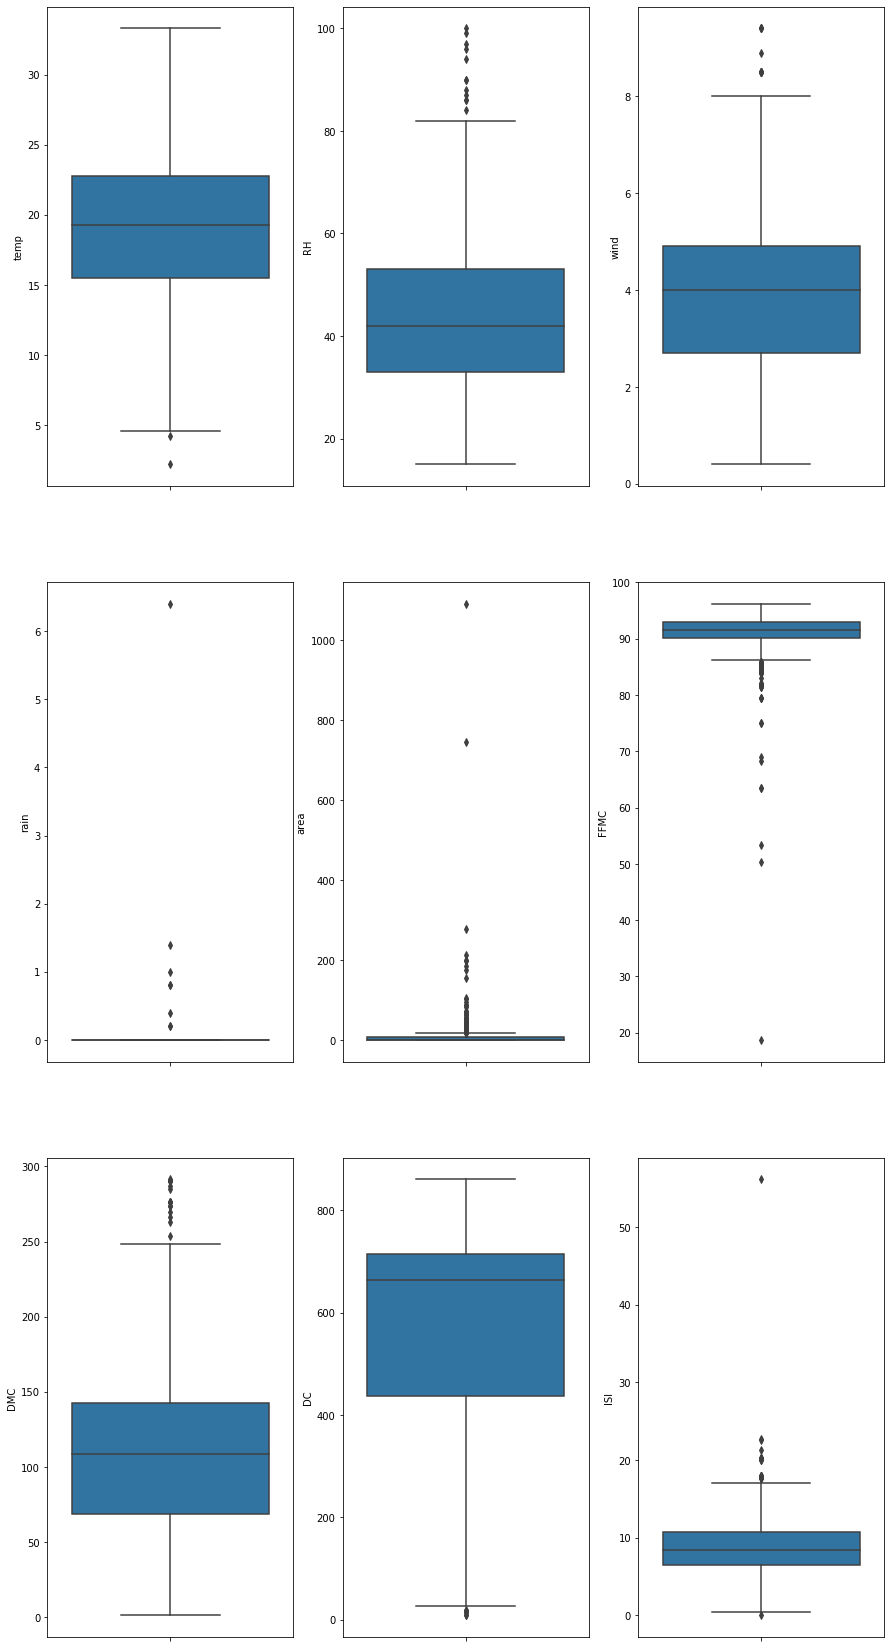

In [11]:
f, axes = plt.subplots(3, 3, figsize=(15,30))

sns.boxplot(y="temp", data=fire, ax=axes[0, 0])
sns.boxplot(y="RH", data=fire, ax=axes[0, 1])
sns.boxplot(y="wind", data=fire, ax=axes[0, 2])
sns.boxplot(y="rain", data=fire, ax=axes[1, 0])
sns.boxplot(y="area", data=fire, ax=axes[1, 1])
sns.boxplot(y='FFMC', data=fire, ax=axes[1, 2])
sns.boxplot(y='DMC', data=fire, ax=axes[2, 0])
sns.boxplot(y='DC', data=fire, ax=axes[2, 1])
sns.boxplot(y='ISI', data=fire, ax=axes[2, 2])

Outlier masing-masing kolom berada pada:
- temp < 5
- RH > 80
- wind > 8
- rain > 0
- area > 175
- FFMC < 80
- DMC > 250
- DC < 20
- ISI > 20

### Transformasi Data
Teknik transformasi data yang akan digunakan dalam notebook ini adalah boxcox yang akan diaplikasikan pada kolom area sehingga dapat menormalisasi eror serta memperbaiki prediksi model. 

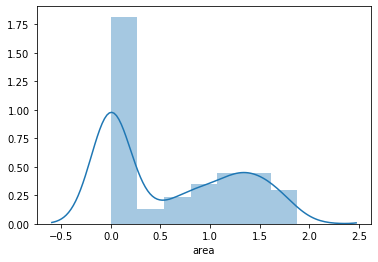

In [12]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

fire['area'] = boxcox(fire['area'] + 1)[0]
sns.distplot(fire['area'])

Walaupun belum dapat dikatakan sebagai distribusi normal, data area setelah transformasi dapat dikatakan memiliki distribusi yang lebih baik dibanding sebelumnya.

Selanjutnya akan dilihat persebaran data tiap kolom dibandingkan dengan persebaran data area yang telah ditransformasikan.

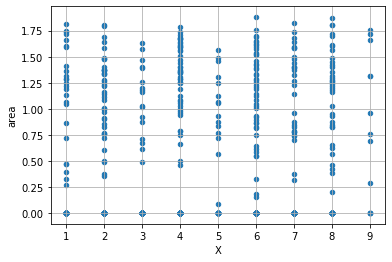

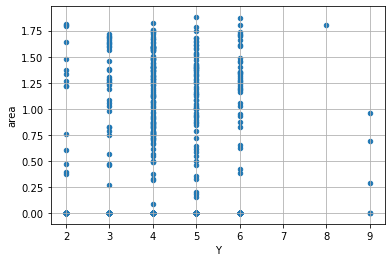

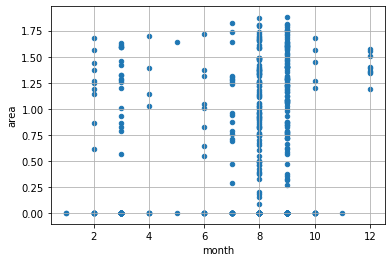

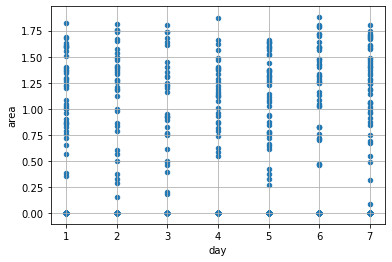

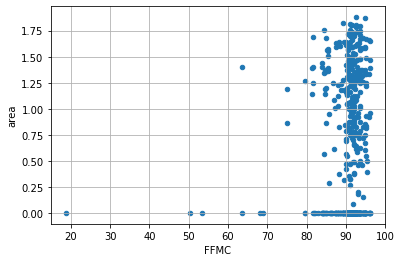

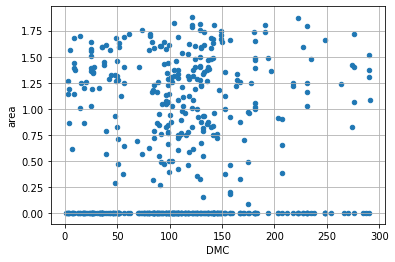

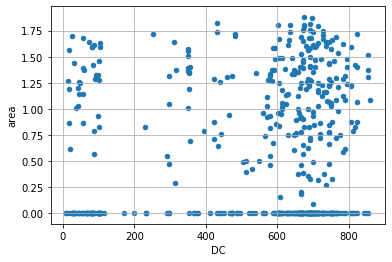

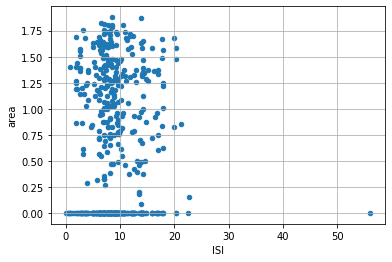

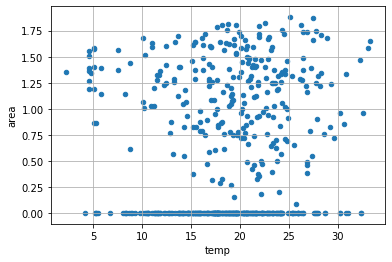

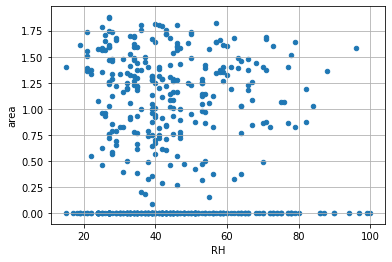

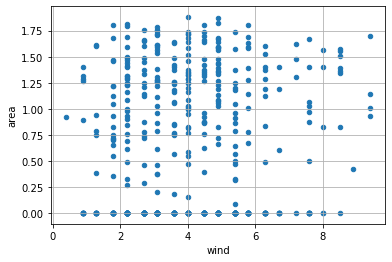

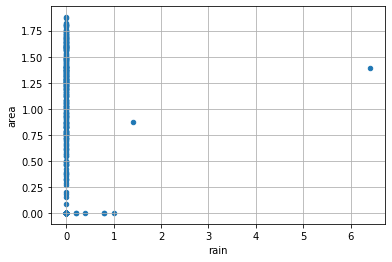

In [13]:
for i in fire.describe().columns[:-1]:
    fire.plot.scatter(i,'area',grid=True)

Setelah penggunaan transformasi data kolom area, persebaran data kolom lain terhadap kolom area dapat dilihat dengan lebih jelas.

## Eksperimen dengan Model Neural Network
Pada bagian ini, akan dilakukan beberapa eksperimen terhadap beberapa model neural network untuk mencari model dengan kemampuan prediksi yang lebih baik dibanding model lain (yang digunakan dalam notebook ini.

### Feature Selection
Dari informasi yang telah dikumpulkan melalui pengumpulan informasi awal dataset dan eksplorasi data di atas, disimpulkan bahwa terdapat beberapa kolom fitur yang tidak terlalu memberikan banyak pengaruh terhadap prediksi luas area kebakaran hutan. Kolom ini adalah X, Y, month, day, ISI, RH, dan rain. Oleh karenanya sebelum membuat model, kolom-kolom yang telah disebutkan akan terlebih dahulu didrop.

1. LSTM tanpa Feature Selection

In [14]:
from sklearn.preprocessing import MinMaxScaler
copy = fire

X_data = copy.drop(['area'], axis = 1)
X = X_data.values
y = copy['area'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [15]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train = np.reshape(scaled_train,(scaled_train.shape[0], scaled_train.shape[1], 1))
scaled_test = np.reshape(scaled_test,(scaled_test.shape[0], scaled_test.shape[1], 1))

In [16]:
model = Sequential()
model.add(LSTM(units = 50, activation='relu', input_shape = (X_train.shape[1],1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mean_absolute_error'])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
exp_1 = model.fit(scaled_train, y_train, validation_data=(scaled_test, y_test), nb_epoch=150,batch_size=len(scaled_train), verbose=1, shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 361 samples, validate on 156 samples
Epoch 1/150
361/361 [==============================] - 0s 809us/step - loss: 0.8122 - mean_absolute_error: 0.6247 - val_loss: 0.9827 - val_mean_absolute_error: 0.6427
Epoch 2/150
361/361 [==============================] - 0s 72us/step - loss: 0.7898 - mean_absolute_error: 0.6099 - val_loss: 0.9482 - val_mean_absolute_error: 0.6392
Epoch 3/150
361/361 [==============================] - 0s 61us/step - loss: 0.7684 - mean_absolute_error: 0.6066 - val_loss: 0.9151 - val_mean_absolute_error: 0.6381
Epoch 4/150
361/361 [==============================] - 0s 66us/step - loss: 0.7480 - mean_absolute_error: 0.6053 - val_loss: 0.8835 - val_mean_absolute_error: 0.6371
Epoch 5/150
361/361 [==============================] - 0s 89us/step - loss: 0.7285 - mean_absolute_error: 0.6041 - val_loss: 0.8534 - val_mean_absolute_error: 0.6366
Epoch 6/150
361/361 [==============================] - 0s 66us/step - loss:

Epoch 49/150
361/361 [==============================] - 0s 66us/step - loss: 0.4302 - mean_absolute_error: 0.5955 - val_loss: 0.4647 - val_mean_absolute_error: 0.6206
Epoch 50/150
361/361 [==============================] - 0s 44us/step - loss: 0.4297 - mean_absolute_error: 0.5955 - val_loss: 0.4652 - val_mean_absolute_error: 0.6208
Epoch 51/150
361/361 [==============================] - 0s 46us/step - loss: 0.4291 - mean_absolute_error: 0.5956 - val_loss: 0.4658 - val_mean_absolute_error: 0.6211
Epoch 52/150
361/361 [==============================] - 0s 70us/step - loss: 0.4286 - mean_absolute_error: 0.5958 - val_loss: 0.4666 - val_mean_absolute_error: 0.6214
Epoch 53/150
361/361 [==============================] - 0s 68us/step - loss: 0.4281 - mean_absolute_error: 0.5960 - val_loss: 0.4674 - val_mean_absolute_error: 0.6218
Epoch 54/150
361/361 [==============================] - 0s 71us/step - loss: 0.4276 - mean_absolute_error: 0.5962 - val_loss: 0.4683 - val_mean_absolute_error: 0.622

Epoch 99/150
361/361 [==============================] - 0s 55us/step - loss: 0.4199 - mean_absolute_error: 0.5956 - val_loss: 0.4992 - val_mean_absolute_error: 0.6290
Epoch 100/150
361/361 [==============================] - 0s 54us/step - loss: 0.4199 - mean_absolute_error: 0.5955 - val_loss: 0.4988 - val_mean_absolute_error: 0.6289
Epoch 101/150
361/361 [==============================] - 0s 82us/step - loss: 0.4198 - mean_absolute_error: 0.5955 - val_loss: 0.4983 - val_mean_absolute_error: 0.6288
Epoch 102/150
361/361 [==============================] - 0s 66us/step - loss: 0.4197 - mean_absolute_error: 0.5955 - val_loss: 0.4978 - val_mean_absolute_error: 0.6287
Epoch 103/150
361/361 [==============================] - 0s 66us/step - loss: 0.4196 - mean_absolute_error: 0.5954 - val_loss: 0.4973 - val_mean_absolute_error: 0.6286
Epoch 104/150
361/361 [==============================] - 0s 66us/step - loss: 0.4196 - mean_absolute_error: 0.5954 - val_loss: 0.4968 - val_mean_absolute_error: 

Epoch 148/150
361/361 [==============================] - 0s 66us/step - loss: 0.4171 - mean_absolute_error: 0.5942 - val_loss: 0.4756 - val_mean_absolute_error: 0.6243
Epoch 149/150
361/361 [==============================] - 0s 66us/step - loss: 0.4170 - mean_absolute_error: 0.5942 - val_loss: 0.4753 - val_mean_absolute_error: 0.6243
Epoch 150/150
361/361 [==============================] - 0s 55us/step - loss: 0.4170 - mean_absolute_error: 0.5942 - val_loss: 0.4749 - val_mean_absolute_error: 0.6242


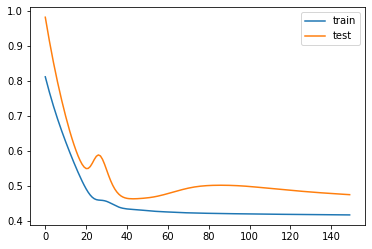

In [18]:
plt.plot(exp_1.history['loss'], label='train')
plt.plot(exp_1.history['val_loss'], label='test')
plt.legend()
plt.show()

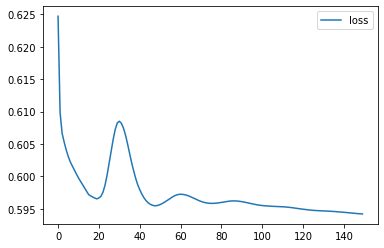

In [19]:
plt.plot(exp_1.history['mean_absolute_error'])
plt.legend(['loss'])

2. LSTM dengan Feature Selection

In [20]:
X_data = copy.drop(['X', 'Y', 'month', 'day', 'ISI', 'RH', 'rain', 'area'], axis = 1)
X = X_data.values
y = copy['area'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [21]:
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train = np.reshape(scaled_train,(scaled_train.shape[0], scaled_train.shape[1], 1))
scaled_test = np.reshape(scaled_test,(scaled_test.shape[0], scaled_test.shape[1], 1))

In [22]:
model = Sequential()
model.add(LSTM(units = 50, activation='relu', input_shape = (X_train.shape[1],1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mean_absolute_error'])

In [23]:
exp_2 = model.fit(scaled_train, y_train, validation_data=(scaled_test, y_test), nb_epoch=150, batch_size=len(scaled_train), verbose=1, shuffle=False)

Train on 361 samples, validate on 156 samples
Epoch 1/150
361/361 [==============================] - 0s 904us/step - loss: 0.7562 - mean_absolute_error: 0.5963 - val_loss: 0.7493 - val_mean_absolute_error: 0.6249
Epoch 2/150
361/361 [==============================] - 0s 29us/step - loss: 0.7447 - mean_absolute_error: 0.5965 - val_loss: 0.7368 - val_mean_absolute_error: 0.6238
Epoch 3/150
361/361 [==============================] - 0s 55us/step - loss: 0.7334 - mean_absolute_error: 0.5968 - val_loss: 0.7244 - val_mean_absolute_error: 0.6227
Epoch 4/150
361/361 [==============================] - 0s 83us/step - loss: 0.7222 - mean_absolute_error: 0.5972 - val_loss: 0.7122 - val_mean_absolute_error: 0.6216
Epoch 5/150
361/361 [==============================] - 0s 27us/step - loss: 0.7111 - mean_absolute_error: 0.5975 - val_loss: 0.7001 - val_mean_absolute_error: 0.6206
Epoch 6/150
361/361 [==============================] - 0s 44us/step - loss: 0.7002 - mean_absolute_error: 0.5978 - val_loss

Epoch 50/150
361/361 [==============================] - 0s 44us/step - loss: 0.4364 - mean_absolute_error: 0.6030 - val_loss: 0.3917 - val_mean_absolute_error: 0.5722
Epoch 51/150
361/361 [==============================] - 0s 24us/step - loss: 0.4364 - mean_absolute_error: 0.6028 - val_loss: 0.3918 - val_mean_absolute_error: 0.5721
Epoch 52/150
361/361 [==============================] - 0s 55us/step - loss: 0.4363 - mean_absolute_error: 0.6024 - val_loss: 0.3918 - val_mean_absolute_error: 0.5720
Epoch 53/150
361/361 [==============================] - 0s 27us/step - loss: 0.4360 - mean_absolute_error: 0.6020 - val_loss: 0.3917 - val_mean_absolute_error: 0.5717
Epoch 54/150
361/361 [==============================] - 0s 28us/step - loss: 0.4356 - mean_absolute_error: 0.6015 - val_loss: 0.3916 - val_mean_absolute_error: 0.5717
Epoch 55/150
361/361 [==============================] - 0s 54us/step - loss: 0.4351 - mean_absolute_error: 0.6010 - val_loss: 0.3915 - val_mean_absolute_error: 0.571

Epoch 100/150
361/361 [==============================] - 0s 28us/step - loss: 0.4258 - mean_absolute_error: 0.5967 - val_loss: 0.3909 - val_mean_absolute_error: 0.5789
Epoch 101/150
361/361 [==============================] - 0s 26us/step - loss: 0.4257 - mean_absolute_error: 0.5966 - val_loss: 0.3909 - val_mean_absolute_error: 0.5789
Epoch 102/150
361/361 [==============================] - 0s 22us/step - loss: 0.4255 - mean_absolute_error: 0.5965 - val_loss: 0.3909 - val_mean_absolute_error: 0.5790
Epoch 103/150
361/361 [==============================] - 0s 44us/step - loss: 0.4254 - mean_absolute_error: 0.5964 - val_loss: 0.3909 - val_mean_absolute_error: 0.5791
Epoch 104/150
361/361 [==============================] - 0s 22us/step - loss: 0.4253 - mean_absolute_error: 0.5963 - val_loss: 0.3909 - val_mean_absolute_error: 0.5792
Epoch 105/150
361/361 [==============================] - 0s 44us/step - loss: 0.4251 - mean_absolute_error: 0.5962 - val_loss: 0.3909 - val_mean_absolute_error:

Epoch 149/150
361/361 [==============================] - 0s 50us/step - loss: 0.4213 - mean_absolute_error: 0.5939 - val_loss: 0.3915 - val_mean_absolute_error: 0.5820
Epoch 150/150
361/361 [==============================] - 0s 22us/step - loss: 0.4212 - mean_absolute_error: 0.5939 - val_loss: 0.3915 - val_mean_absolute_error: 0.5820


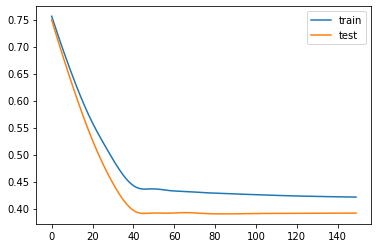

In [24]:
plt.plot(exp_2.history['loss'], label='train')
plt.plot(exp_2.history['val_loss'], label='test')
plt.legend()
plt.show()

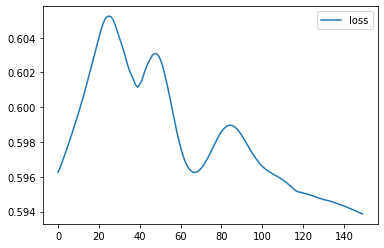

In [25]:
plt.plot(exp_2.history['mean_absolute_error'])
plt.legend(['loss'])

3. Neural Network dengan 3 hidden layer menggunakan Feature Selection

In [26]:
X = X_data.values
y = copy['area'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [27]:
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

scaled_train = np.reshape(scaled_train,(scaled_train.shape[0], scaled_train.shape[1]))
scaled_test = np.reshape(scaled_test,(scaled_test.shape[0], scaled_test.shape[1]))

In [28]:
model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_absolute_error'])

In [29]:
exp_3 = model.fit(scaled_train, y_train, validation_data=(scaled_test, y_test), nb_epoch=150, batch_size=len(scaled_train), verbose=1, shuffle=False)

Train on 361 samples, validate on 156 samples
Epoch 1/150
361/361 [==============================] - 0s 776us/step - loss: 1.4660 - mean_absolute_error: 0.6083 - val_loss: 1.8239 - val_mean_absolute_error: 0.6644
Epoch 2/150
361/361 [==============================] - 0s 0us/step - loss: 1.3902 - mean_absolute_error: 0.6073 - val_loss: 1.7521 - val_mean_absolute_error: 0.6672
Epoch 3/150
361/361 [==============================] - 0s 26us/step - loss: 1.3223 - mean_absolute_error: 0.6064 - val_loss: 1.6831 - val_mean_absolute_error: 0.6694
Epoch 4/150
361/361 [==============================] - 0s 0us/step - loss: 1.2607 - mean_absolute_error: 0.6053 - val_loss: 1.6197 - val_mean_absolute_error: 0.6709
Epoch 5/150
361/361 [==============================] - 0s 0us/step - loss: 1.2033 - mean_absolute_error: 0.6043 - val_loss: 1.5589 - val_mean_absolute_error: 0.6717
Epoch 6/150
361/361 [==============================] - 0s 22us/step - loss: 1.1478 - mean_absolute_error: 0.6032 - val_loss: 1

361/361 [==============================] - 0s 22us/step - loss: 0.4253 - mean_absolute_error: 0.5609 - val_loss: 1.2287 - val_mean_absolute_error: 0.6484
Epoch 51/150
361/361 [==============================] - 0s 22us/step - loss: 0.4201 - mean_absolute_error: 0.5603 - val_loss: 1.2192 - val_mean_absolute_error: 0.6487
Epoch 52/150
361/361 [==============================] - 0s 0us/step - loss: 0.4125 - mean_absolute_error: 0.5604 - val_loss: 1.4187 - val_mean_absolute_error: 0.6502
Epoch 53/150
361/361 [==============================] - 0s 22us/step - loss: 0.4056 - mean_absolute_error: 0.5606 - val_loss: 1.4225 - val_mean_absolute_error: 0.6515
Epoch 54/150
361/361 [==============================] - 0s 0us/step - loss: 0.4076 - mean_absolute_error: 0.5610 - val_loss: 1.4234 - val_mean_absolute_error: 0.6524
Epoch 55/150
361/361 [==============================] - 0s 22us/step - loss: 0.4225 - mean_absolute_error: 0.5613 - val_loss: 1.4143 - val_mean_absolute_error: 0.6531
Epoch 56/150


Epoch 100/150
361/361 [==============================] - 0s 0us/step - loss: 0.3486 - mean_absolute_error: 0.5530 - val_loss: 1.3554 - val_mean_absolute_error: 0.6487
Epoch 101/150
361/361 [==============================] - 0s 0us/step - loss: 0.3628 - mean_absolute_error: 0.5553 - val_loss: 1.3754 - val_mean_absolute_error: 0.6525
Epoch 102/150
361/361 [==============================] - 0s 0us/step - loss: 0.3809 - mean_absolute_error: 0.5581 - val_loss: 1.4426 - val_mean_absolute_error: 0.6556
Epoch 103/150
361/361 [==============================] - 0s 0us/step - loss: 0.4496 - mean_absolute_error: 0.5604 - val_loss: 1.4448 - val_mean_absolute_error: 0.6584
Epoch 104/150
361/361 [==============================] - 0s 18us/step - loss: 0.4622 - mean_absolute_error: 0.5626 - val_loss: 1.4478 - val_mean_absolute_error: 0.6609
Epoch 105/150
361/361 [==============================] - 0s 0us/step - loss: 0.5004 - mean_absolute_error: 0.5644 - val_loss: 1.4507 - val_mean_absolute_error: 0.66

Epoch 149/150
361/361 [==============================] - 0s 0us/step - loss: 0.4146 - mean_absolute_error: 0.5499 - val_loss: 1.1523 - val_mean_absolute_error: 0.6369
Epoch 150/150
361/361 [==============================] - 0s 27us/step - loss: 0.4144 - mean_absolute_error: 0.5497 - val_loss: 1.1503 - val_mean_absolute_error: 0.6367


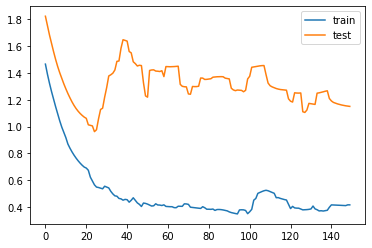

In [30]:
plt.plot(exp_3.history['loss'], label='train')
plt.plot(exp_3.history['val_loss'], label='test')
plt.legend()
plt.show()

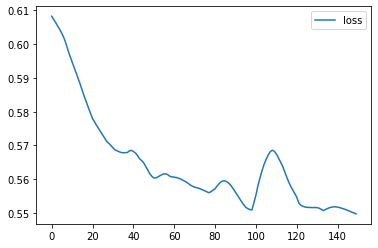

In [31]:
plt.plot(exp_3.history['mean_absolute_error'])
plt.legend(['loss'])

Terdapat 3 eksperimen yang tercantum dalam notebook ini, dengan hasil sebagai berikut:
- loss terendah didapat pada eksperimen ketiga, yaitu NN dengan 3 Hidden Layer menggunakan Feature Selection dengan nilai 0.4144.
- val_loss terendah didapat pada eksperimen kedua, yaitu LSTM dengan Feature Selection dengan nilai 0.3915.
- Dari plot yang digunakan untuk memetakan loss training terhadap val_loss testing, eksperimen terbaik adalah eksperimen kedua.
- Diputuskan untuk tidak menggunakan callbacks seperti early stopping dan model checkpoint, sebab dalam percobaannya malah membuat nilai loss dan val_loss lebih tinggi dibanding tidak menggunakan keduanya.
- Diputuskan menggunakan sebanyak 64 input node pada percobaan ketiga sebab memiliki output yang lebih baik dibanding menggunakan node yang lebih sedikit (32, 16, 12).
- Diputuskan hanya menggunakan 3 hidden layer pada percobaan ketiga sebab penambahan layer (menjadi 5) memiliki output yang tidak terlalu berbeda jauh dengan hanya menggunakan 3.
- Diputuskan hanya menggunakan 8 node pada masing-masing hidden layer pada percobaan ketiga sebab penambahan node (32, 20, 16, 12) memiliki output yang kurang baik.